**Problem statement**

The problem that I want to introduce and solve is a problem of binary classification; I want to define and train a model able to recognize if a bottle is open or closed looking at its image.

Let's import required libraries and read training data from Googl Drive


In [0]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


**Let's see how an image of our dataset looks like**

How you can see this is an image of an ope bottle (it's not completely closed)

In [0]:
img = mpimg.imread('/content/gdrive/My Drive/tappi/open/training_open_bottle_1.jpg')
type(img)
img.shape

(2976, 3968, 3)

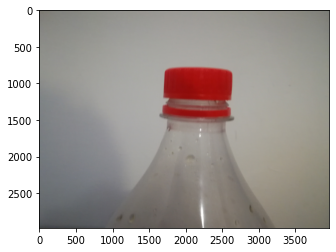

In [0]:
imgplot = plt.imshow(img)

Now it's time to load all images on a dataset for training data.
We will use ImageDataGenerator class. It allows to load both training and validation data from file system. It is "smart" because let you define different labels for sets of images stored on different subfolders.
In our case we have **"open bottles" images** under open subfolders and " bottles" images under closed subfolder,

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
dim_x=140
dim_y=140
dim_kernel=(3,3)

In [0]:
data_gen= ImageDataGenerator(rescale=1/255,validation_split=0.2)
data_dir=os.path.join('/content/gdrive/My Drive/tappi')

train_data_generator=data_gen.flow_from_directory( 
    data_dir,
    target_size=(dim_x,dim_y),
    batch_size=8,
    class_mode='binary',
    subset='training')

validation_data_generator=data_gen.flow_from_directory( 
    data_dir,
    target_size=(dim_x,dim_y),
    batch_size=8,
    class_mode='binary',
    subset='validation')

Found 259 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [0]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

# **Let's build the model**

The modelthat we are going to build has four Convolutional layers (Conv2D + Maxpool2D ); after them there is a flatten layer that adapts output of the ladst MAxPool2d to a Dense layer that we will use in the next layer. Last Layer has to have just one layer because we need to predict 0 or 1 values; we want to predict only two values (open|closed).

In [0]:
model = Sequential()

# CONVOLUTIONAL LAYER
model.add(Conv2D(filters=16, kernel_size=dim_kernel,input_shape=(dim_x, dim_y, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=dim_kernel,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=dim_kernel,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=dim_kernel,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=dim_kernel,activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())

# 128 NEURONS IN DENSE HIDDEN LAYER (YOU CAN CHANGE THIS NUMBER OF NEURONS)
model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# https://keras.io/metrics/
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # we can add in additional metrics https://keras.io/metrics/

We can use a callback to avoid to go on with more epochs on training phase even if the model has already reached a good accurancy value; in this phase we can be happy with val_accurancy > 0.9

In [0]:
from tensorflow.keras.callbacks import Callback
class MyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_accuracy = logs["val_accuracy"]
        accuracy = logs["accuracy"]
        if (accuracy >= self.threshold) and (accuracy>self.threshold):
            self.model.stop_training = True
mtc=MyThresholdCallback(0.9)

It's time to train the model, we will use 10 epochs

In [0]:
model.fit(
    train_data_generator,
    steps_per_epoch=30,
    epochs=10,
    validation_data=validation_data_generator,
    validation_steps=8
    ,callbacks=[mtc]
    )

Epoch 1/10
30/30 [==============================] - 57s 2s/step - loss: 0.6950 - accuracy: 0.5208 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 2/10
30/30 [==============================] - 56s 2s/step - loss: 0.6907 - accuracy: 0.4979 - val_loss: 0.6684 - val_accuracy: 0.5156
Epoch 3/10
30/30 [==============================] - 56s 2s/step - loss: 0.5697 - accuracy: 0.7191 - val_loss: 0.3550 - val_accuracy: 0.9062
Epoch 4/10
30/30 [==============================] - 56s 2s/step - loss: 0.2695 - accuracy: 0.8979 - val_loss: 0.0275 - val_accuracy: 1.0000
Epoch 5/10
30/30 [==============================] - 56s 2s/step - loss: 0.1894 - accuracy: 0.9234 - val_loss: 0.1695 - val_accuracy: 0.9531


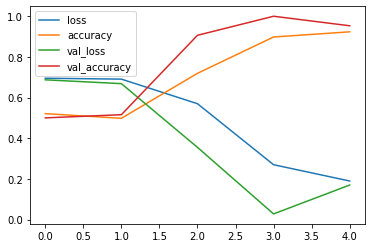

In [0]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Ok accurancy seems very well, but we want to compare current model with previous ones; thus we need retrieve already saved model, calculate its accurancy and compare it with the current one.

In [0]:
import tensorflow as tf
old_model = tf.keras.models.load_model('./gdrive/My Drive/best_model_tappi_CNN.h5')
_,accurancy_old=old_model.evaluate(validation_data_generator,steps=8,batch_size=8,verbose=1)
_,accurancy_new=model.evaluate(validation_data_generator,steps=8,batch_size=8,verbose=1)
if(accurancy_new>accurancy_old):
  model.save('./gdrive/My Drive/best_model_tappi_CNN.h5')
else:
  model=old_model
#model.save('./gdrive/My Drive/best_model_tappi_CNN.h5')

8/8 [==============================] - 10s 1s/step - loss: 0.1654 - accuracy: 0.9531


In [0]:
#model = tf.keras.models.load_model('./gdrive/My Drive/best_model_tappi_CNN.h5')

Now we have best model, it's time to test our module against data it has never seen. First of all we need to define a function that, receiving the model and the path of the image, is able to to 

1) read the image

2) adapt its shape to that one used within the model

3) Normalize data to values belonging to [0,1] range

4) and finally predict the category which the image belongs to (open,closed)


In [0]:
from keras.preprocessing.image import   img_to_array, load_img
import tensorflow as tf
def evaluate_image(model_target,image_file,show_image=True):
  img = mpimg.imread(image_file)
  if(show_image):
    plt.imshow(img)
  img=tf.image.resize(img, (140,140))

  x = img_to_array(img)
  x=x/255            
  x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
  
  pred=model.predict(x)
  if pred[0][0]<0.5:
    return "closed",pred[0][0]
  else: 
    return "open",pred[0][0]  

Using TensorFlow backend.


('closed', 0.032619577)

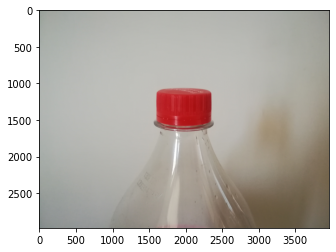

In [0]:
evaluate_image(model,'/content/gdrive/My Drive/tappi-test/closed/test_closed_bottle_0.jpg')

('open', 0.99966156)

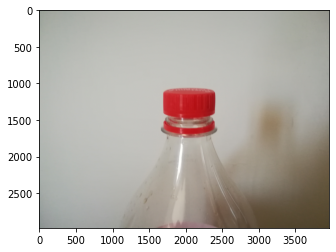

In [0]:
evaluate_image(model,'/content/gdrive/My Drive/tappi-test/open/test_open_bottle_0.jpg')

('closed', 7.36329e-05)

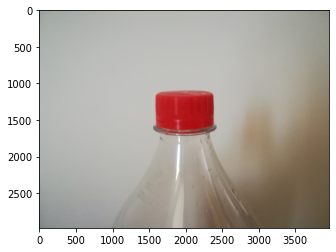

In [0]:
evaluate_image(model,'/content/gdrive/My Drive/tappi-test/closed/test_closed_bottle_1.jpg')

('open', 0.9997131)

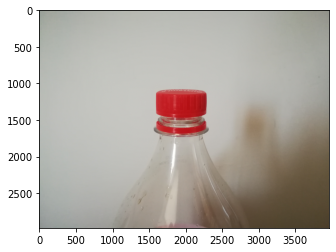

In [0]:
evaluate_image(model,'/content/gdrive/My Drive/tappi-test/open/test_open_bottle_3.jpg')

('open', 0.6351962)

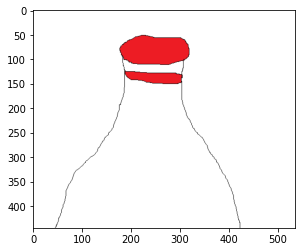

In [0]:
evaluate_image(model,'/content/gdrive/My Drive/tappi-test/open/test_open_bottle_5.png')

('closed', 0.0422334)

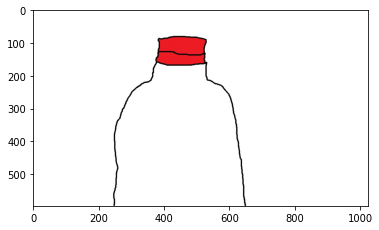

In [0]:
evaluate_image(model,'/content/gdrive/My Drive/tappi-test/closed/test_closed_bottle_5.jpg')

# It's fantastic!!! Our model is able to predict correctly all images categories; it is able to predict even bottles designed roughly with MS Paint!!! 
# I'm happy with it!!